In [1]:
# After running this cell, check http://localhost:4040 (spark dashboard)
# and you will see apache spark running.
from pyspark import SparkContext 
sc = SparkContext.getOrCreate()

In [2]:
# https://academo.org/demos/estimating-pi-monte-carlo/
import random
num_samples = 1000000

# This function will be parallelized using spark
def inside(p):     
    x, y = random.random(), random.random()
    return x*x + y*y < 1


count = sc.parallelize(range(0, num_samples)).filter(inside).count()
pi = 4 * count / num_samples
print(pi)

3.142352


In [3]:
csvreader = spark.read.format("csv").option("header", "true")
df = csvreader.load("data/breadbasket_dms.csv")

df.registerTempTable("breadbasket")

print(type(df))
print(df.printSchema())
print(df.describe().show())
df.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Transaction: string (nullable = true)
 |-- Item: string (nullable = true)

None
+-------+----------+--------+------------------+----------------+
|summary|      Date|    Time|       Transaction|            Item|
+-------+----------+--------+------------------+----------------+
|  count|     21293|   21293|             21293|           21293|
|   mean|      null|    null| 4951.990889024562|            null|
| stddev|      null|    null|2787.7583996983885|            null|
|    min|2016-10-30|01:21:05|                 1|      Adjustment|
|    max|2017-04-09|23:38:41|               999|Victorian Sponge|
+-------+----------+--------+------------------+----------------+

None
+----------+--------+-----------+-------------+
|      Date|    Time|Transaction|         Item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|201

In [14]:
df.show(20)

+----------+--------+-----------+-------------+
|      Date|    Time|Transaction|         Item|
+----------+--------+-----------+-------------+
|2016-10-30|09:58:11|          1|        Bread|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:05:34|          2| Scandinavian|
|2016-10-30|10:07:57|          3|Hot chocolate|
|2016-10-30|10:07:57|          3|          Jam|
|2016-10-30|10:07:57|          3|      Cookies|
|2016-10-30|10:08:41|          4|       Muffin|
|2016-10-30|10:13:03|          5|       Coffee|
|2016-10-30|10:13:03|          5|       Pastry|
|2016-10-30|10:13:03|          5|        Bread|
|2016-10-30|10:16:55|          6|    Medialuna|
|2016-10-30|10:16:55|          6|       Pastry|
|2016-10-30|10:16:55|          6|       Muffin|
|2016-10-30|10:19:12|          7|    Medialuna|
|2016-10-30|10:19:12|          7|       Pastry|
|2016-10-30|10:19:12|          7|       Coffee|
|2016-10-30|10:19:12|          7|          Tea|
|2016-10-30|10:20:51|          8|       

In [6]:
spark.sql("SHOW tables").show()

+--------+-----------+-----------+
|database|  tableName|isTemporary|
+--------+-----------+-----------+
|        |breadbasket|       true|
+--------+-----------+-----------+



In [26]:
m = spark.sql("""
SELECT 
        int(Transaction) as ticket_id,
        count(*) as num_items,
        CONCAT(max(Date),' ',max(Time)) as ticket_date,
        collect_list(Item) as ticket_items,
        approx_count_distinct(Item) as ticket_uniqueitems
    FROM breadbasket 
    GROUP BY ticket_id 
    ORDER BY ticket_id
""")


m.show()

+---------+---------+-------------------+--------------------+------------------+
|ticket_id|num_items|        ticket_date|        ticket_items|ticket_uniqueitems|
+---------+---------+-------------------+--------------------+------------------+
|        1|        1|2016-10-30 09:58:11|             [Bread]|                 1|
|        2|        2|2016-10-30 10:05:34|[Scandinavian, Sc...|                 1|
|        3|        3|2016-10-30 10:07:57|[Hot chocolate, J...|                 3|
|        4|        1|2016-10-30 10:08:41|            [Muffin]|                 1|
|        5|        3|2016-10-30 10:13:03|[Coffee, Pastry, ...|                 3|
|        6|        3|2016-10-30 10:16:55|[Medialuna, Pastr...|                 3|
|        7|        4|2016-10-30 10:19:12|[Medialuna, Pastr...|                 4|
|        8|        2|2016-10-30 10:20:51|     [Pastry, Bread]|                 2|
|        9|        2|2016-10-30 10:21:59|     [Bread, Muffin]|                 2|
|       10|     

In [25]:
from pyspark.sql.functions import collect_list, approx_count_distinct

q = df.groupby(df.Transaction).agg(collect_list("Item"), approx_count_distinct("Item"))
q.show()

+-----------+--------------------+---------------------------+
|Transaction|  collect_list(Item)|approx_count_distinct(Item)|
+-----------+--------------------+---------------------------+
|       1090|[Brownie, Coffee,...|                          4|
|       1159|             [Bread]|                          1|
|       1436|      [Coffee, Soup]|                          2|
|       1512|[Hearty & Seasona...|                          3|
|       1572|    [Pastry, Coffee]|                          2|
|       2069|             [Bread]|                          1|
|       2088|      [Scandinavian]|                          1|
|       2136|[Hot chocolate, Tea]|                          2|
|       2162|[Coffee, Tea, Jui...|                          7|
|       2294|         [Tea, NONE]|                          2|
|       2904|[NONE, Sandwich, ...|                          4|
|        296|[Farm House, Scan...|                          2|
|       3210|      [Bread, Bread]|                     

In [28]:
from pyspark.sql.functions import explode

z = m.withColumn("item",explode(m.ticket_items))
z.show()

+---------+---------+-------------------+--------------------+------------------+-------------+
|ticket_id|num_items|        ticket_date|        ticket_items|ticket_uniqueitems|         item|
+---------+---------+-------------------+--------------------+------------------+-------------+
|        1|        1|2016-10-30 09:58:11|             [Bread]|                 1|        Bread|
|        2|        2|2016-10-30 10:05:34|[Scandinavian, Sc...|                 1| Scandinavian|
|        2|        2|2016-10-30 10:05:34|[Scandinavian, Sc...|                 1| Scandinavian|
|        3|        3|2016-10-30 10:07:57|[Hot chocolate, J...|                 3|Hot chocolate|
|        3|        3|2016-10-30 10:07:57|[Hot chocolate, J...|                 3|          Jam|
|        3|        3|2016-10-30 10:07:57|[Hot chocolate, J...|                 3|      Cookies|
|        4|        1|2016-10-30 10:08:41|            [Muffin]|                 1|       Muffin|
|        5|        3|2016-10-30 10:13:03

In [29]:
z.toPandas()

,ticket_id,num_items,ticket_date,ticket_items,ticket_uniqueitems,item
0,1,1,2016-10-30 09:58:11,[Bread],1,Bread
1,2,2,2016-10-30 10:05:34,"[Scandinavian, Scandinavian]",1,Scandinavian
2,2,2,2016-10-30 10:05:34,"[Scandinavian, Scandinavian]",1,Scandinavian
3,3,3,2016-10-30 10:07:57,"[Hot chocolate, Jam, Cookies]",3,Hot chocolate
4,3,3,2016-10-30 10:07:57,"[Hot chocolate, Jam, Cookies]",3,Jam
...,...,...,...,...,...,...
21288,9682,4,2017-04-09 14:32:58,"[Muffin, Tacos/Fajita, Coffee, Tea]",4,Coffee
21289,9682,4,2017-04-09 14:32:58,"[Muffin, Tacos/Fajita, Coffee, Tea]",4,Tea
21290,9683,2,2017-04-09 14:57:06,"[Coffee, Pastry]",2,Coffee
21291,9683,2,2017-04-09 14:57:06,"[Coffee, Pastry]",2,Pastry


In [34]:
s = z.groupBy("ticket_id").pivot("item").count().na.fill(0)

In [35]:
s.show()

+---------+----------+------------------------+---------+---------------+--------+-----+--------+--------+------------+------+-------------+-----+-------------+------------------+-------+----+-------------+---------------------+------------+------------+---------------+----------+----------------+------+----------------+----+-------+------+------+--------------------------+--------+--------------+----+----------------------+---------+--------------------+-----------+----------+--------+--------+-----+------------+-----------------+-------+--------------+-------------------+-----------------+-----+-------------+---+--------------+-----+----------------+------------+-----------------+---------+--------------+-------------+--------+------+------+----------------+----+---------+--------------+--------+------+------------------+-------+-------+--------+-----------------------------+--------+-----+--------+------------+-----+--------+---------+----+--------------+------+------------+-------+

In [51]:
print(len(s.columns))
s.count()

96


9531

In [41]:
s.select(["ticket_id","Bread","Jam"]).show()

+---------+-----+---+
|ticket_id|Bread|Jam|
+---------+-----+---+
|        1|    1|  0|
|        2|    0|  0|
|        3|    0|  1|
|        4|    0|  0|
|        5|    1|  0|
|        6|    0|  0|
|        7|    0|  0|
|        8|    1|  0|
|        9|    1|  0|
|       10|    0|  0|
|       11|    2|  0|
|       12|    0|  1|
|       13|    1|  0|
|       14|    1|  0|
|       15|    0|  0|
|       16|    1|  0|
|       17|    0|  0|
|       18|    0|  0|
|       19|    1|  0|
|       20|    1|  0|
+---------+-----+---+
only showing top 20 rows



In [42]:
s.select(s.columns[:5]).show()

+---------+----------+------------------------+---------+---------------+
|ticket_id|Adjustment|Afternoon with the baker|Alfajores|Argentina Night|
+---------+----------+------------------------+---------+---------------+
|        1|         0|                       0|        0|              0|
|        2|         0|                       0|        0|              0|
|        3|         0|                       0|        0|              0|
|        4|         0|                       0|        0|              0|
|        5|         0|                       0|        0|              0|
|        6|         0|                       0|        0|              0|
|        7|         0|                       0|        0|              0|
|        8|         0|                       0|        0|              0|
|        9|         0|                       0|        0|              0|
|       10|         0|                       0|        0|              0|
|       11|         0|                

In [44]:
s.filter("Bread >= 2").select(["ticket_id","Bread","Jam"]).show()

+---------+-----+---+
|ticket_id|Bread|Jam|
+---------+-----+---+
|       11|    2|  0|
|      194|    2|  0|
|      281|    2|  0|
|      474|    2|  0|
|      489|    2|  0|
|      541|    2|  0|
|      565|    2|  0|
|      948|    2|  0|
|      986|    2|  0|
|     1037|    2|  0|
|     1168|    2|  0|
|     1189|    2|  0|
|     1206|    2|  0|
|     1238|    2|  0|
|     1254|    2|  0|
|     1259|    2|  0|
|     1297|    2|  0|
|     1318|    2|  0|
|     1336|    2|  0|
|     1458|    2|  0|
+---------+-----+---+
only showing top 20 rows



In [48]:
a = s.select(["ticket_id","Bread","Jam"])
x = a.drop("ticket_id")
x.show()

+-----+---+
|Bread|Jam|
+-----+---+
|    1|  0|
|    0|  0|
|    0|  1|
|    0|  0|
|    1|  0|
|    0|  0|
|    0|  0|
|    1|  0|
|    1|  0|
|    0|  0|
|    2|  0|
|    0|  1|
|    1|  0|
|    1|  0|
|    0|  0|
|    1|  0|
|    0|  0|
|    0|  0|
|    1|  0|
|    1|  0|
+-----+---+
only showing top 20 rows



In [52]:
from sklearn.decomposition import PCA

df = s.toPandas()
display(df.head())

pca_model = PCA(n_components=2)
values = pca_model.fit_transform(df)

,ticket_id,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
values

array([[-4.84148988e+03, -7.40172198e-01],
       [-4.84048989e+03, -4.11312748e-01],
       [-4.83948988e+03, -3.54887235e-01],
       ...,
       [ 4.83951012e+03,  4.33160206e-01],
       [ 4.84051012e+03,  5.05842717e-01],
       [ 4.84151012e+03, -4.46765473e-01]])

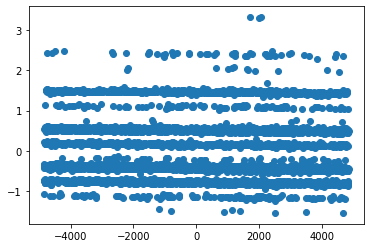

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.scatter(values[:,0],values[:,1])